In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications.resnet50 import preprocess_input
import os
from sklearn.utils import class_weight

# Check for GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('MPS'):
    print("MPS is available and will be used for acceleration.")

batch_size = 16
img_height = 256
img_width = 256
data_dir = 'multi_cancer'

# Create training and validation datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical',
    color_mode='rgb',
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

# Grab class names from dataset
class_names = train_ds.class_names
print("Class names:", class_names)

# --- NEW: Calculate Class Weights ---
print("Calculating class weights...")
all_labels = []
class_counts = {}
# Iterate through the original directory to get total counts (approximation for training set)
for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    if os.path.exists(class_path):
        count = len(os.listdir(class_path))
        class_counts[class_name] = count
        all_labels.extend([class_names.index(class_name)] * count)

print("Class counts (total):", class_counts)

class_weights_vals = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)
class_weights = dict(enumerate(class_weights_vals))
print("Class weights:", class_weights)
# ------------------------------------

Num GPUs Available:  0
Found 101517 files belonging to 16 classes.
Using 81214 files for training.
Found 101517 files belonging to 16 classes.
Using 20303 files for validation.
Class names: ['brain_glioma', 'brain_menin', 'brain_tumor', 'breast_benign', 'breast_malignant', 'cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'colon_aca', 'colon_bnt', 'kidney_normal', 'kidney_tumor', 'lung_aca', 'lung_bnt', 'lung_scc']
Calculating class weights...
Class counts (total): {'brain_glioma': 5000, 'brain_menin': 5000, 'brain_tumor': 5000, 'breast_benign': 5000, 'breast_malignant': 5000, 'cervix_dyk': 5000, 'cervix_koc': 5000, 'cervix_mep': 5000, 'cervix_pab': 5000, 'colon_aca': 5000, 'colon_bnt': 5000, 'kidney_normal': 9235, 'kidney_tumor': 7284, 'lung_aca': 10000, 'lung_bnt': 10000, 'lung_scc': 10000}
Class weights: {0: np.float64(1.2689875), 1: np.float64(1.2689875), 2: np.float64(1.2689875), 3: np.float64(1.2689875), 4: np.float64(1.2689875), 5: np.float64(1.2689875), 6: np.float64(1.26

In [8]:
from tensorflow.keras.applications import ResNet50

In [9]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),

    # Intensity robustness (VERY important)
    layers.RandomContrast(0.25),
    layers.RandomBrightness(0.25),

    # Color robustness (key for colorized datasets)
    layers.RandomSaturation(0.2),
    layers.RandomHue(0.05),
])

def preprocess_train(image, label):
    # Assume images are already RGB (3 channels)
    x = data_augmentation(image)
    x = preprocess_input(x)  # e.g., tf.keras.applications.resnet50.preprocess_input
    return x, label

def preprocess_val(image, label):
    # Assume images are already RGB
    x = preprocess_input(image)
    return x, label

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(preprocess_train, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(preprocess_val, num_parallel_calls=AUTOTUNE)

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

train_ds = train_ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)  # remove .cache()
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)  # remove .cache()

num_classes = len(class_names)

# Base model
base_model = ResNet50(
    input_shape=(256, 256, 3),  # RGB
    include_top=False,
    weights="imagenet"
)

# Freeze layers except last 30
for layer in base_model.layers[:-30]:
    layer.trainable = False


In [10]:
inputs = keras.Input(shape=(256,256,3))

# Base ResNet50
x = base_model(inputs, training=True)  # keep batchnorm active for fine-tuning

# Conv2D to adjust feature depth
x = keras.layers.Conv2D(
    512,
    kernel_size=1,
    activation='relu',
    kernel_regularizer=keras.regularizers.l2(1e-4)
)(x)

# Global Average Pooling
x = keras.layers.GlobalAveragePooling2D()(x)

# Dense head
x = keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.45)(x)

# Output
outputs = keras.layers.Dense(16, activation='softmax', kernel_regularizer=keras.regularizers.l2(1e-4))(x)

# Compile
model = keras.Model(inputs, outputs)

loss_fn = keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
optimizer = keras.optimizers.Adam(learning_rate=3e-5)

model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])


early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# epochs = 10 
# print("Starting training with class weights...")
# history = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=epochs,
#     callbacks=[early_stop],
#     class_weight=class_weights 
# )

# model.save('cancer_model_weighted.keras')
# print("Model saved to cancer_model_weighted.keras")


In [11]:
# MAKE SURE TO TRAIN AGAIN!

In [12]:
epochs = 5
print("Starting training with class weights...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stop],
    class_weight=class_weights 
)

Starting training with class weights...
Epoch 1/5


2026-01-25 19:47:44.098443: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:41: Filling up shuffle buffer (this may take a while): 801 of 1000
2026-01-25 19:47:46.748482: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


5076/5076 ━━━━━━━━━━━━━━━━━━━━ 1765s 344ms/step - accuracy: 0.8244 - loss: 1.1948 - val_accuracy: 0.8392 - val_loss: 1.1891
Epoch 2/5


2026-01-25 20:17:05.758244: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:41: Filling up shuffle buffer (this may take a while): 819 of 1000
2026-01-25 20:17:07.964821: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


5076/5076 ━━━━━━━━━━━━━━━━━━━━ 1732s 339ms/step - accuracy: 0.9304 - loss: 0.9282 - val_accuracy: 0.9260 - val_loss: 0.9450
Epoch 3/5


2026-01-25 20:45:57.791003: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:41: Filling up shuffle buffer (this may take a while): 808 of 1000
2026-01-25 20:46:00.152830: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


5076/5076 ━━━━━━━━━━━━━━━━━━━━ 1738s 340ms/step - accuracy: 0.9538 - loss: 0.8552 - val_accuracy: 0.9246 - val_loss: 0.9388
Epoch 4/5


2026-01-25 21:14:55.766756: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:41: Filling up shuffle buffer (this may take a while): 826 of 1000
2026-01-25 21:14:57.912783: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


5076/5076 ━━━━━━━━━━━━━━━━━━━━ 1754s 343ms/step - accuracy: 0.9635 - loss: 0.8094 - val_accuracy: 0.9571 - val_loss: 0.8259
Epoch 5/5


2026-01-25 21:44:09.445140: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:41: Filling up shuffle buffer (this may take a while): 833 of 1000
2026-01-25 21:44:11.474695: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


5076/5076 ━━━━━━━━━━━━━━━━━━━━ 1799s 352ms/step - accuracy: 0.9709 - loss: 0.7762 - val_accuracy: 0.9692 - val_loss: 0.7606


In [25]:
import numpy as np
from sklearn.metrics import classification_report

# 1. Ensure val_ds is set to shuffle=False in your setup code!
# 2. Collect predictions and labels in one go to ensure 1:1 alignment
all_labels = []
all_preds = []

print("Generating predictions...")
for images, labels in val_ds:
    # Get predictions for the current batch
    preds = model.predict(images, verbose=0)
    
    # Save the true labels and the predicted labels
    all_labels.extend(np.argmax(labels.numpy(), axis=1))
    all_preds.extend(np.argmax(preds, axis=1))

# 3. Convert to numpy arrays
y_true = np.array(all_labels)
y_pred = np.array(all_preds)

# 4. Handle the "10 vs 16" class mismatch
# This identifies which classes actually exist in your validation set
present_classes = np.unique(y_true)
present_names = [class_names[i] for i in present_classes]

# 5. Generate the report
report = classification_report(
    y_true, 
    y_pred, 
    labels=present_classes, 
    target_names=present_names
)

print(report)

Generating predictions...


KeyboardInterrupt: 

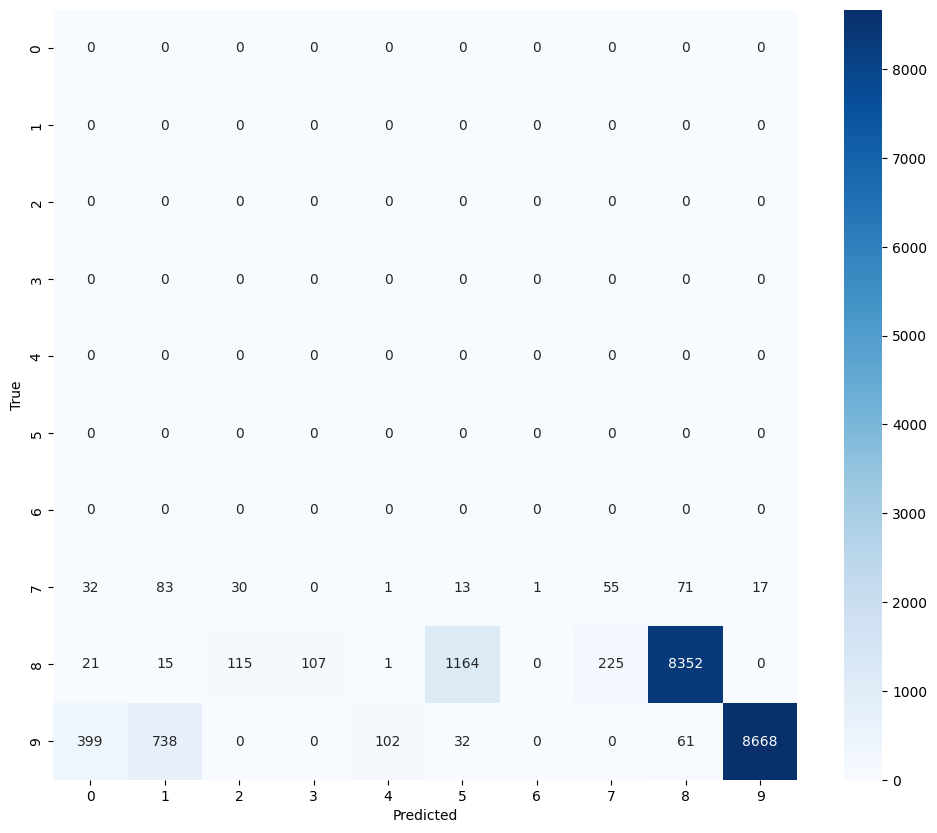

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [15]:
class_names

['brain_glioma',
 'brain_menin',
 'brain_tumor',
 'breast_benign',
 'breast_malignant',
 'cervix_dyk',
 'cervix_koc',
 'cervix_mep',
 'cervix_pab',
 'colon_aca',
 'colon_bnt',
 'kidney_normal',
 'kidney_tumor',
 'lung_aca',
 'lung_bnt',
 'lung_scc']

In [15]:
model.save("cancer_model.keras")